# Classification and Regression Trees
by Elliot Cohen, Ph.D.  

**Requirements**: Python 3.6 with the following packages: `pandas`, `numpy`, `scikit-learn`, `pydotplus`, `IPython`  
You can install packages in a Jupyter Notebook as follows:
```!pip install <package>```

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble

from IPython.display import Image
import pydotplus  # NOTE: May Require conda install graphviz

## Example 1: Classification Trees

In [ ]:
# import data
header_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/field_names.txt'
data_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/breast-cancer.csv'

header_list = pd.read_csv(header_url, header=None, squeeze=True).tolist();
data = pd.read_csv(data_url, header=None, names=header_list, index_col='ID')

In [ ]:
# divide data into predictors (X) and predictand (y), and subdivide into test/train sets.
Y = data['diagnosis'].replace({'M': True, 'B': False}) # convert to binary outcome
X = data.iloc[:, data.columns != 'diagnosis']

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.4)

In [ ]:
# fit a classifier
clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
clf.fit(x_train, y_train)

In [ ]:
# evaluate the classifier
print(metrics.classification_report(y_true=y_test, y_pred=clf.predict(x_test)))

In [ ]:
# visualize the classifier
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [ ]:
# evaluate feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Feature_importance': clf.feature_importances_})
feature_importance.sort_values('Feature_importance', ascending=False).head(5)

## Discussion:
1. Which paramter(s) control under-fitting vs over-fitting?
2. How do we know when to stop feature splits in a "greedy" function?
3. Name two ways we can evaluate feature importance?

## Example 2: Regresssion Trees

In [3]:
# now let's try with a continuous target varialbe
yellow_taxi_url = 'https://raw.githubusercontent.com/Ecohen4/data-viz/project/project/weatherCabDataViz.csv'
taxi_data = pd.DataFrame.from_csv(yellow_taxi_url)
taxi_data.apply(pd.Categorical).describe()

occupancy  rainSnowStatus  holWkend
count      8619.0            8619      8619
unique     8016.0               5         2
top        5243.9               0         0
freq          4.0            8004      5913

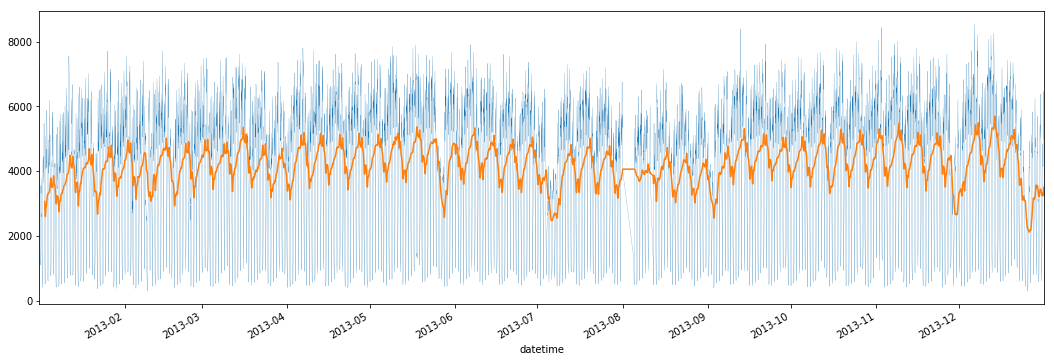

In [5]:
# visualize a period of interest
start, end = taxi_data.index[0], taxi_data.index[-1]
taxi_data.loc[start:end].occupancy.plot(figsize=(18,6), linewidth=0.2)
taxi_data.loc[start:end].occupancy.rolling(window=48).mean().plot(figsize=(18,6))

In [28]:
target = taxi_data['occupancy']
features = taxi_data.loc[:, taxi_data.columns != 'occupancy']
type(features)

pandas.core.frame.DataFrame

In [55]:
# timeseries cross-validation
def time_series_cross_validation(target, features, classifier, model_name, n_splits=10):
    y = target
    scaler = preprocessing.StandardScaler().fit(features)
    X = scaler.transform(features)
    
    # time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        classifier.fit(X_train, y_train)
        y_hat=classifier.predict(X_test)
        explained_variance = metrics.explained_variance_score(y_true=y_test, y_pred=y_hat)        
        
        pd.DataFrame({'y_hat': y_hat, 'y_true': y_test}).plot(figsize=(16,4))        
        plt.title('{}\n Cross-Validated Explained Variance Score: {:.2f}'.format(
                model_name, explained_variance)
                 )
        plt.ylabel('NYC Taxi Occupancy')

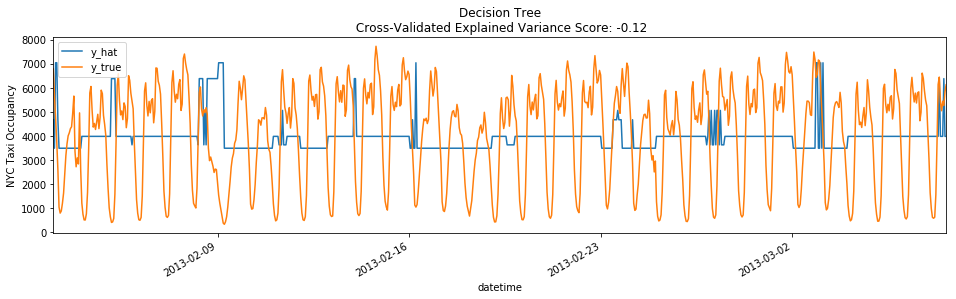

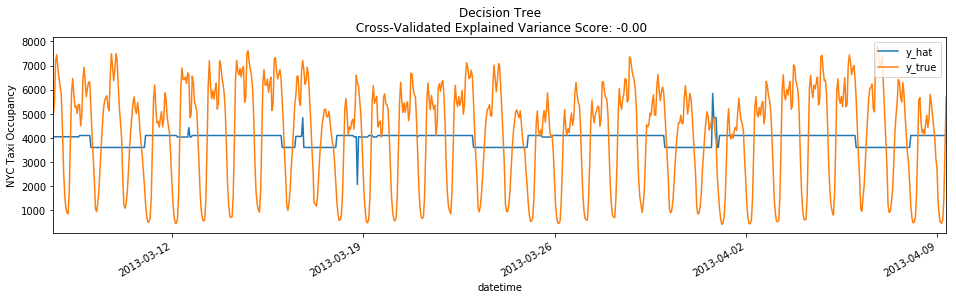

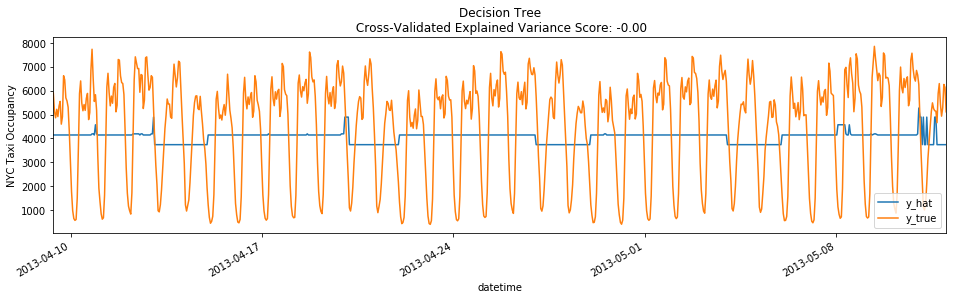

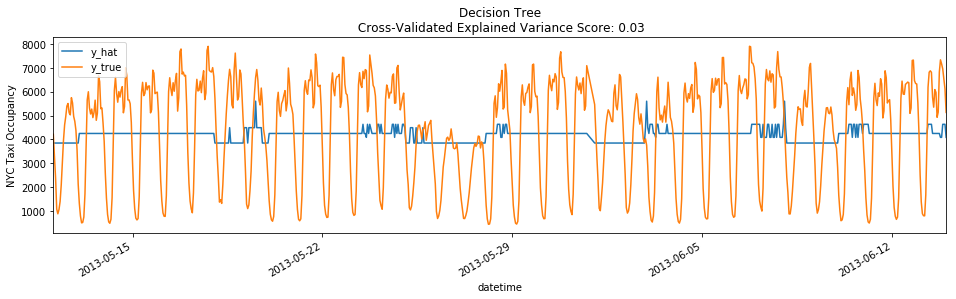

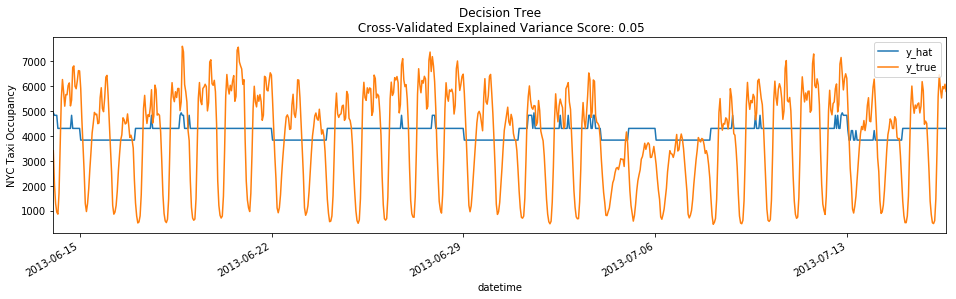

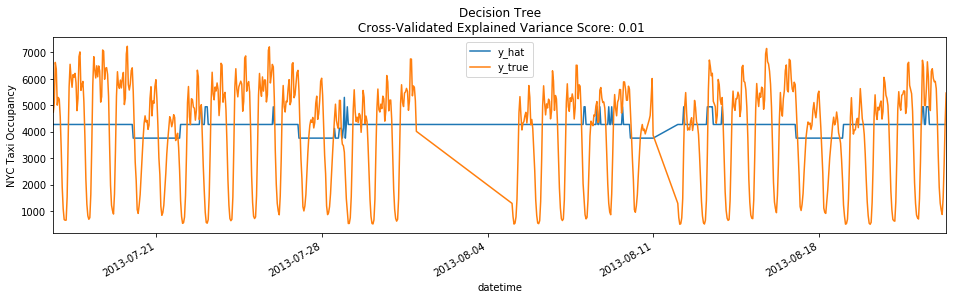

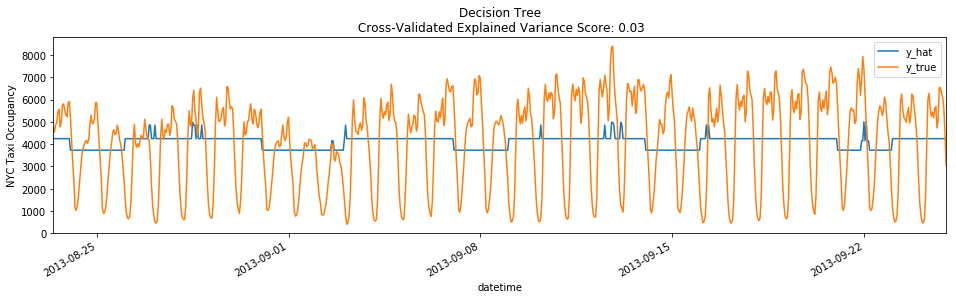

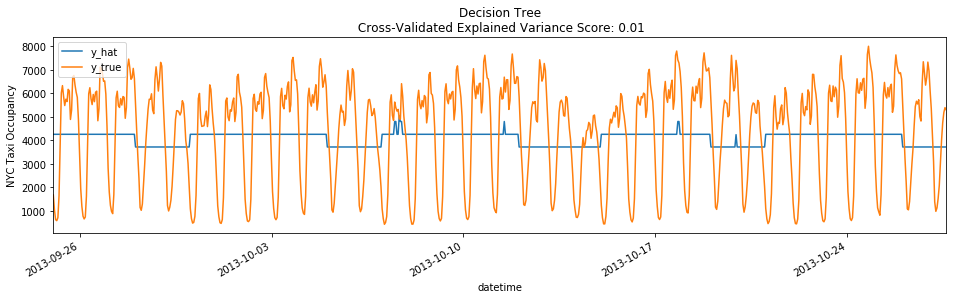

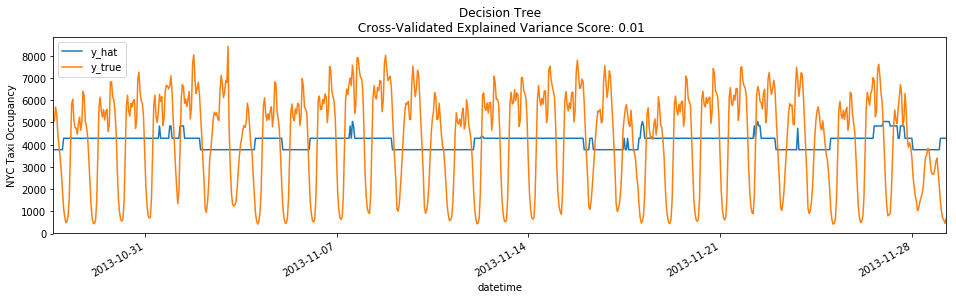

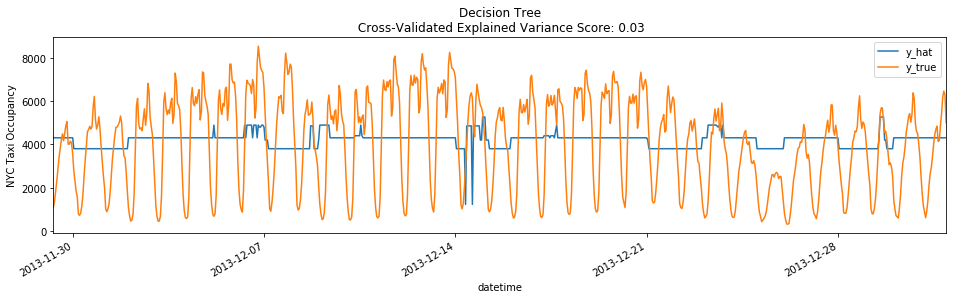

In [56]:
time_series_cross_validation(
    target = taxi_data['occupancy'],
    features = taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=tree.DecisionTreeRegressor(max_depth=5),
    model_name='Decision Tree'
)

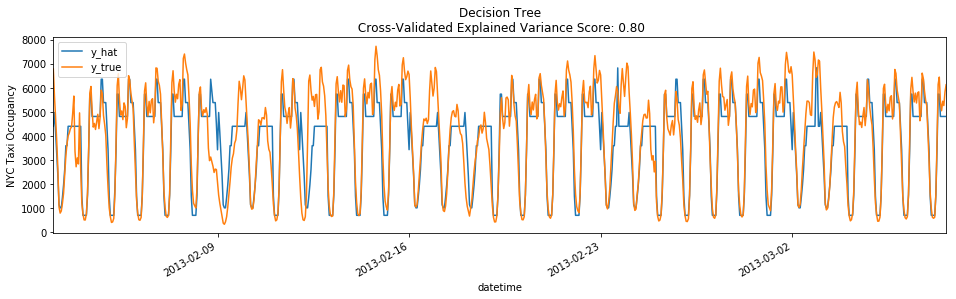

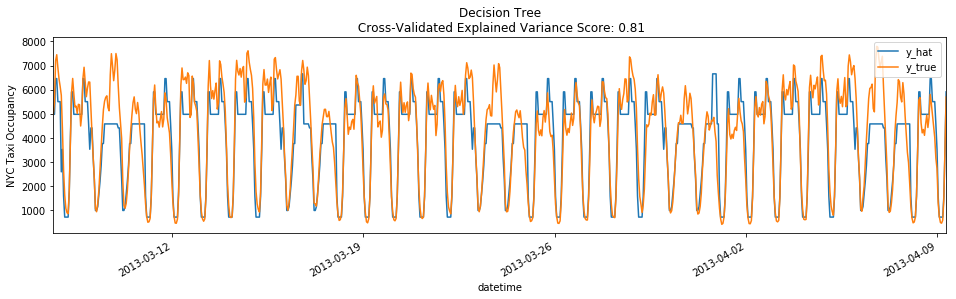

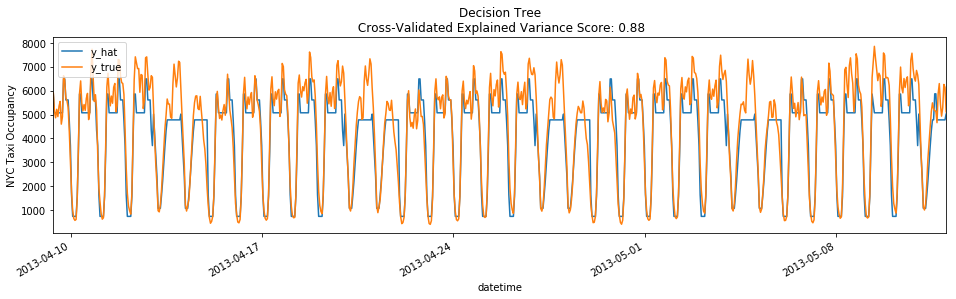

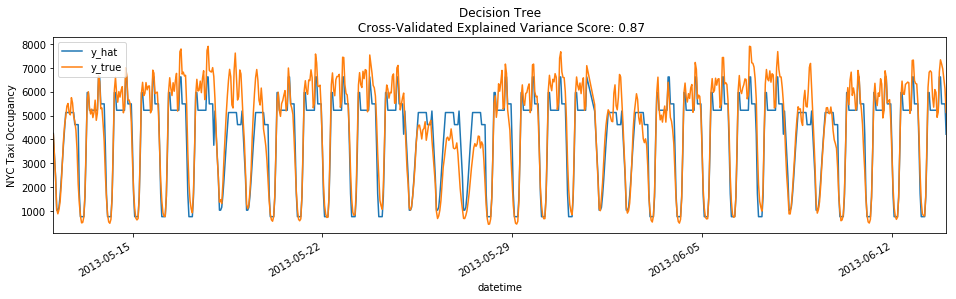

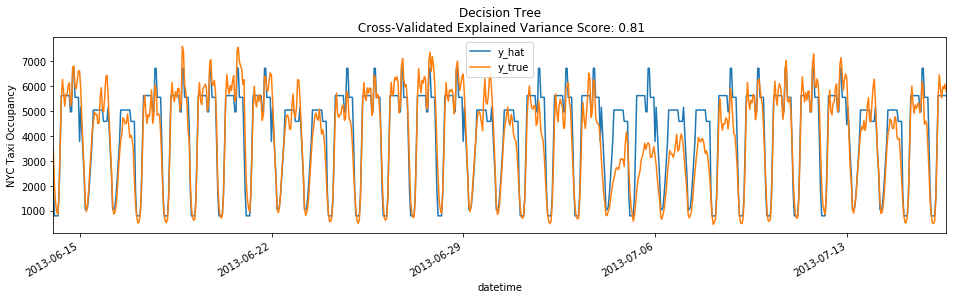

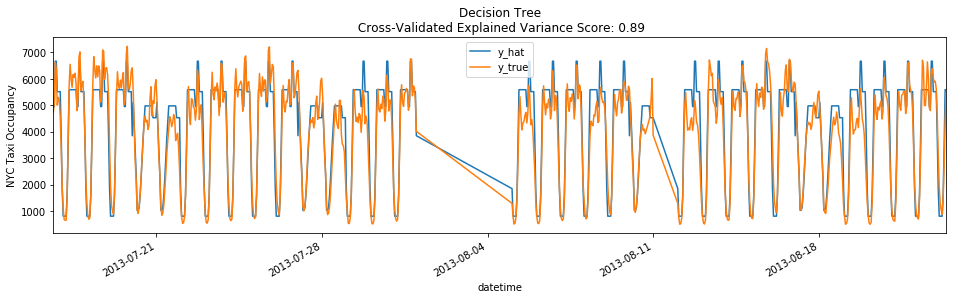

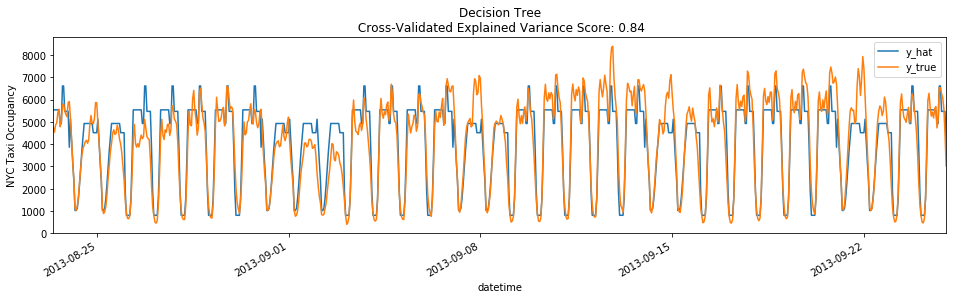

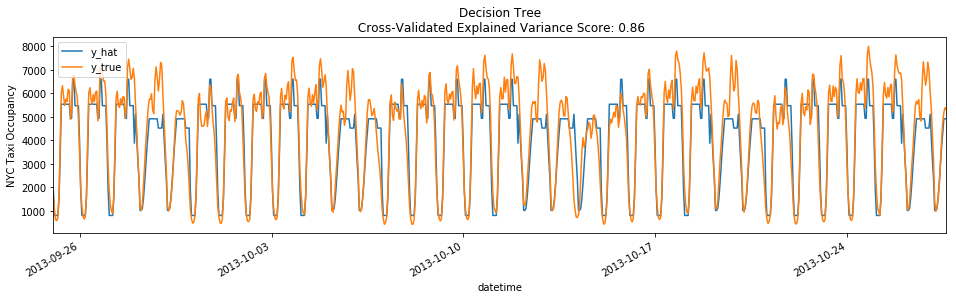

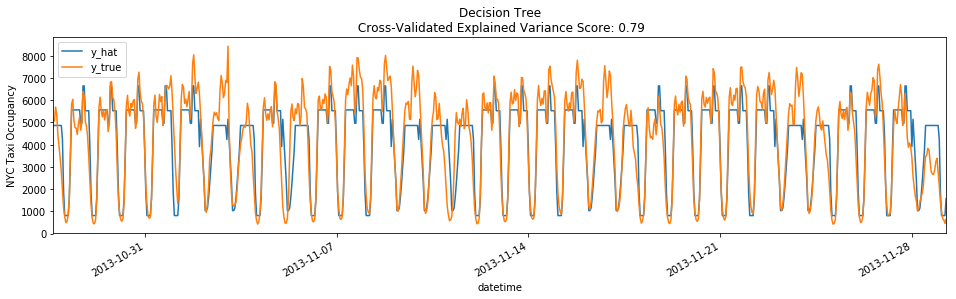

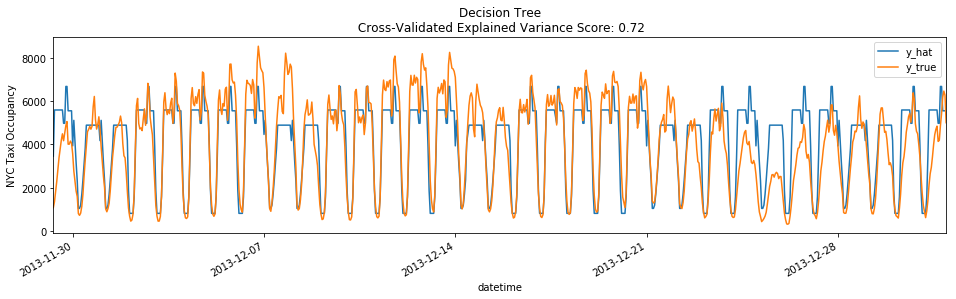

In [58]:
# Results are not so good, huh?
# what feature are we missing?
# let's do some feature engineering to see if we can improve our prediction
taxi_data['timeOfDay'] = taxi_data.index.hour

time_series_cross_validation(
    target = taxi_data['occupancy'],
    features = taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=tree.DecisionTreeRegressor(max_depth=5),
    model_name='Decision Tree'
)

### Discussion:
1. How do classificaiton and regression trees differ?
2. What are special considerations for applying CART to timeseries data?
3. What are other types of problems for which CART are well-suited?

## Example 3: Ensemble Methods

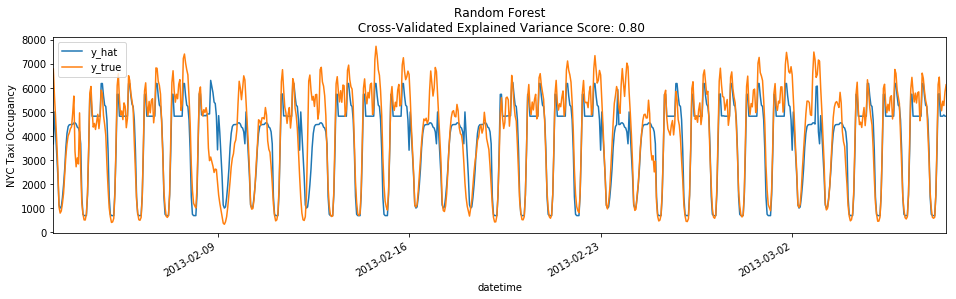

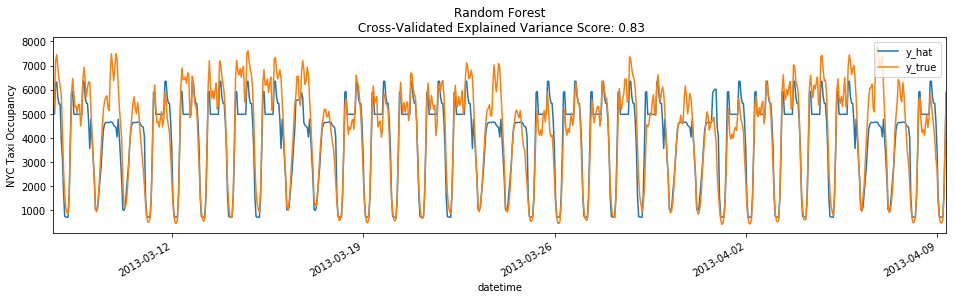

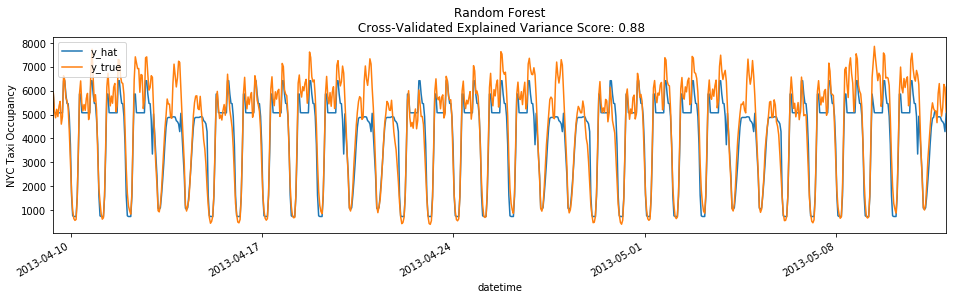

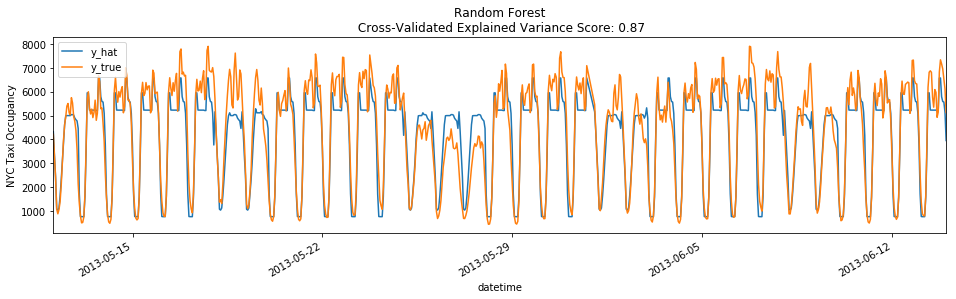

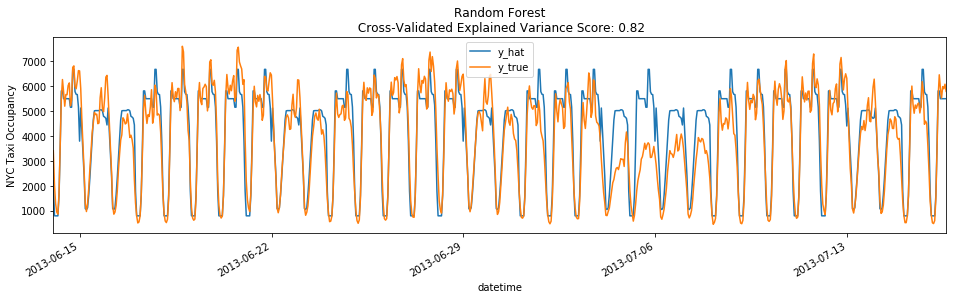

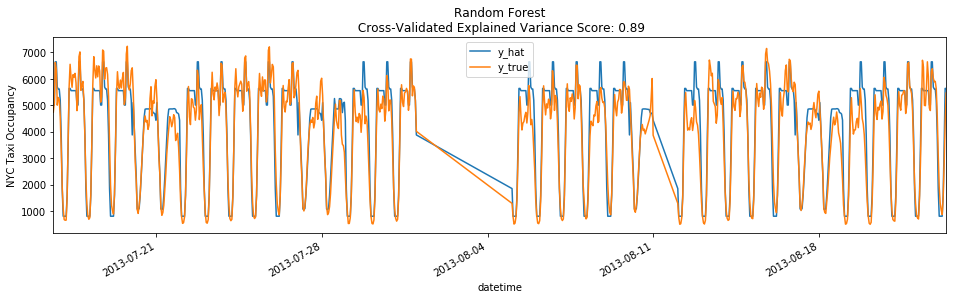

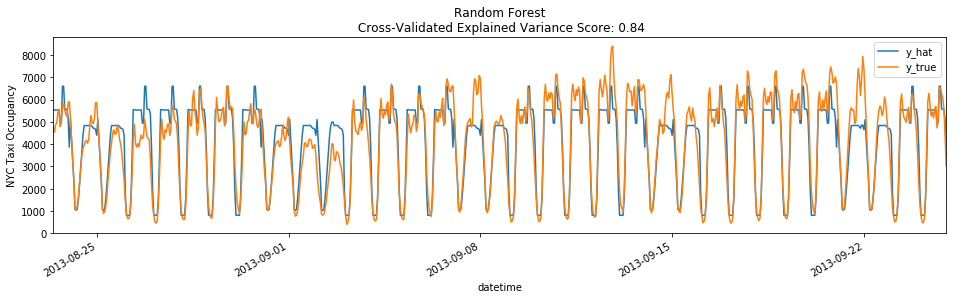

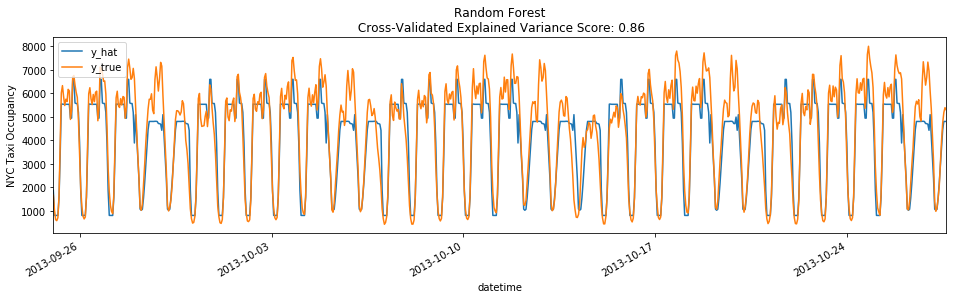

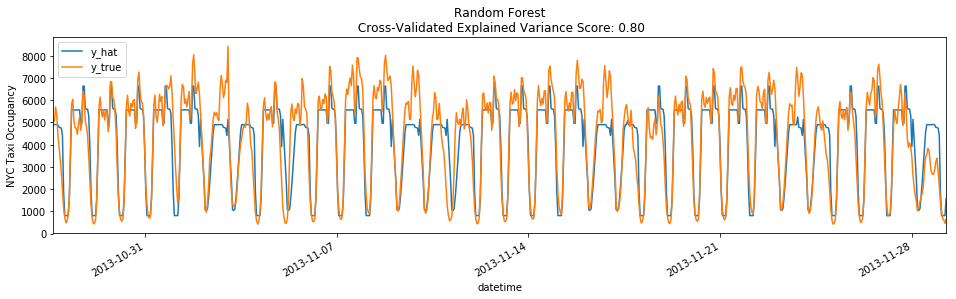

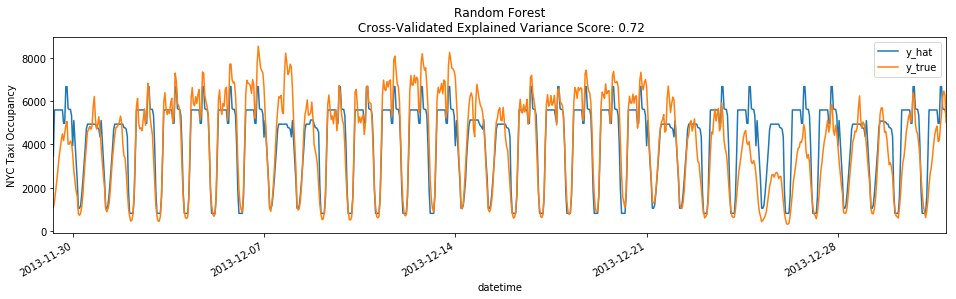

In [59]:
time_series_cross_validation(
    target=taxi_data['occupancy'],
    features=taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=ensemble.RandomForestRegressor(criterion='mse',  # feature-splitting criterion
                                              n_estimators=200, # number of trees
                                              max_depth=5 # max tree depth
                                             ),
    model_name='Random Forest'
)

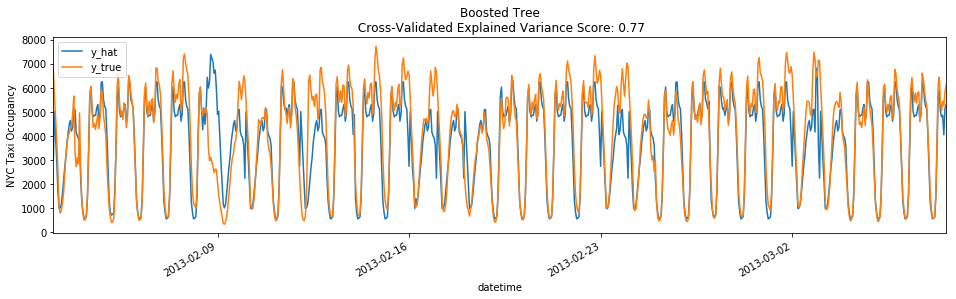

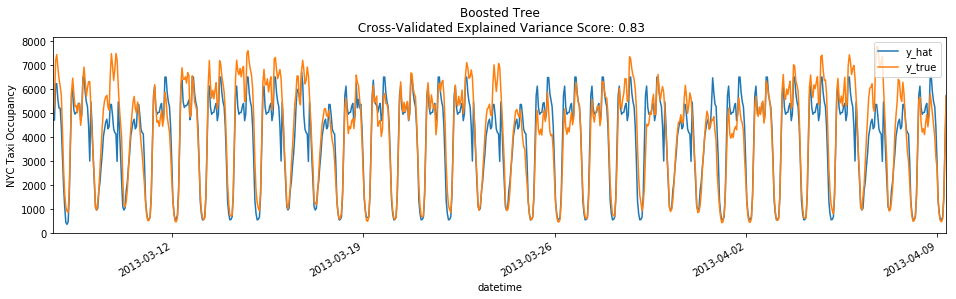

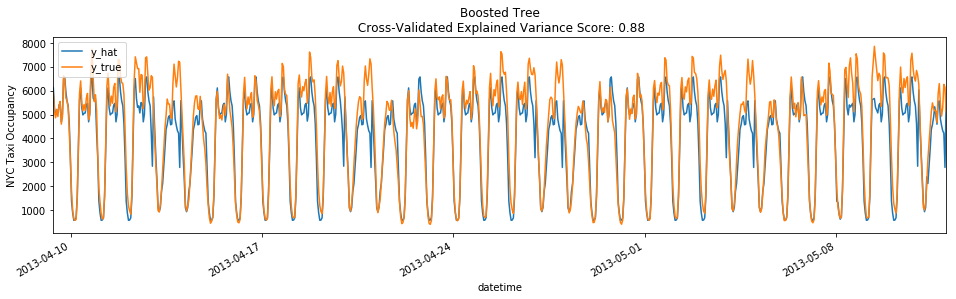

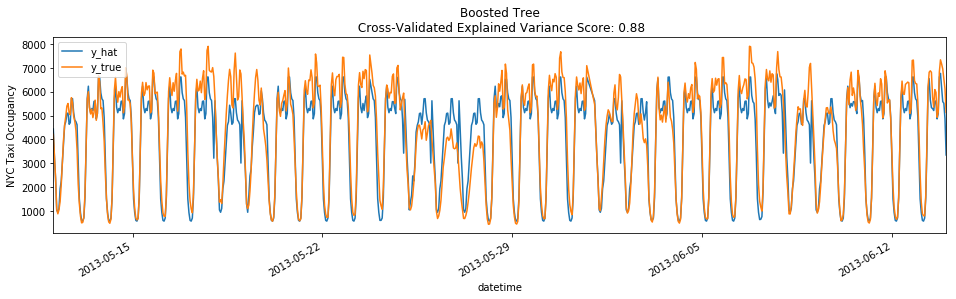

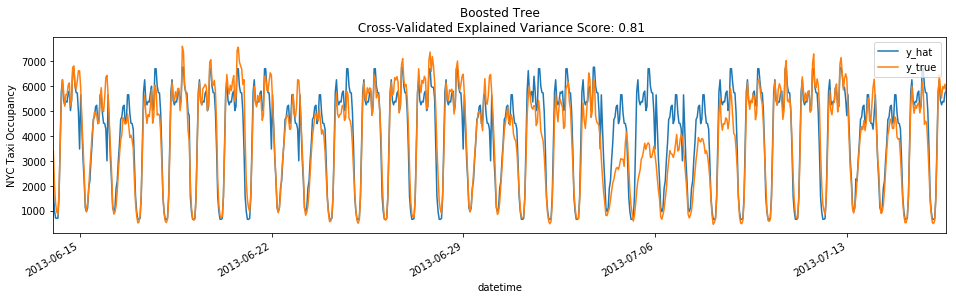

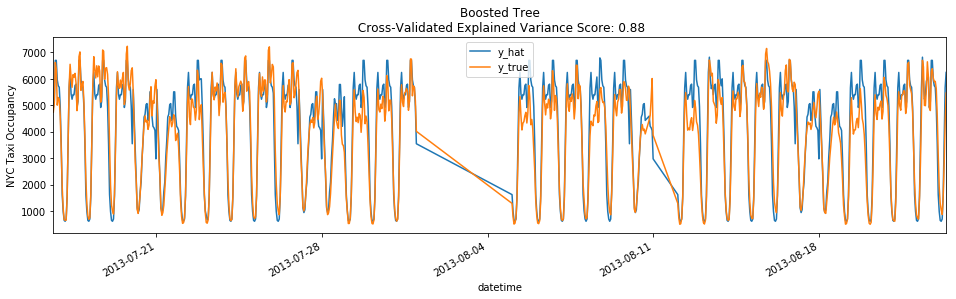

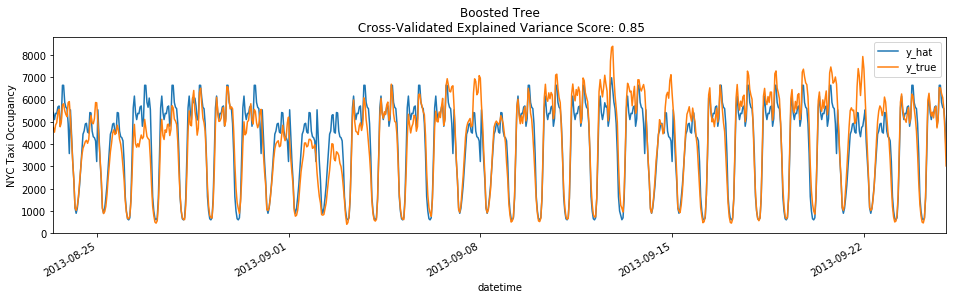

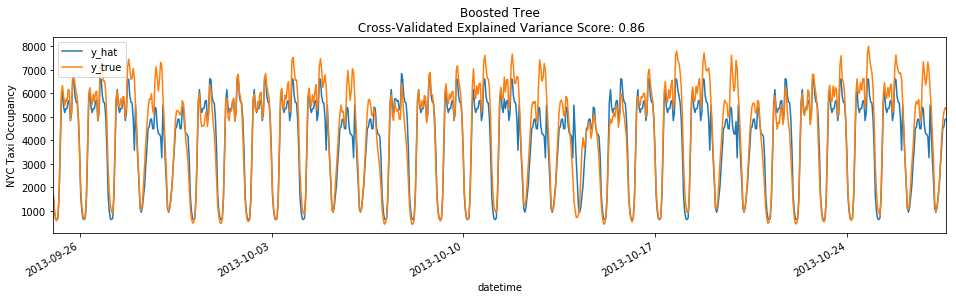

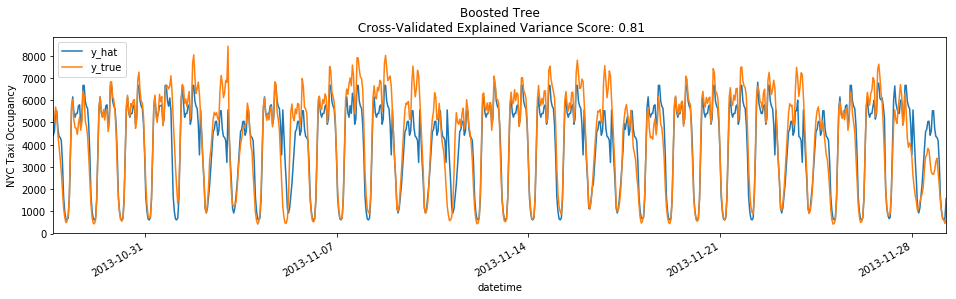

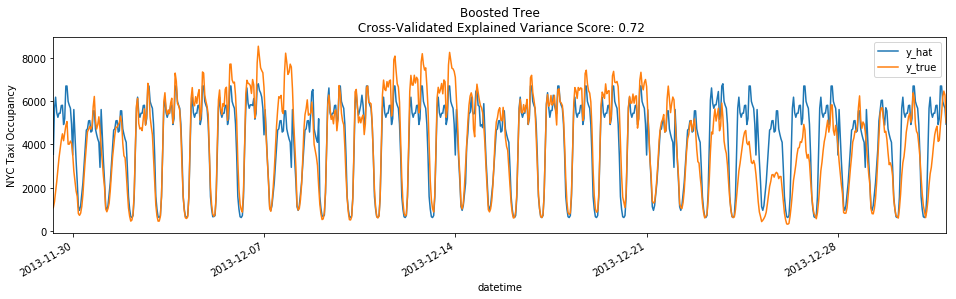

In [61]:
time_series_cross_validation(
    target=taxi_data['occupancy'],
    features=taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=ensemble.GradientBoostingRegressor(criterion='friedman_mse', # feature splitting criterion
                                                  loss='lad', # overall loss function to be minimized
                                                  n_estimators=200 # number of trees
                                                 ),
    model_name='Boosted Tree'
)

## Discussion
1. What is the advantage of ensemble methods?
2. What is the disadvantage of ensemble methods?
3. With so many hyperparameters, how do we "tune" our model?